# Digital Image Processing Final Project - Group 5
* Anders Emmanuel Tan (24/541351/PA/22964) KOMB
* Evan Razzan Adytaputra (24/545257/PA/23166) KOMB
* Indratanaya Budiman (24/534784/PA/22683) KOMA
* Daffa Maulana Siddiq (24/533358/PA/22569) KOMA

**Description**: In this project, we will be attempting to create a Machine Learning model that can detect the existance of Tuberculosis (TBC) based on Lung MRIs. We will be using Tawsifur Rahman's dataset from Kaggle to train our model. However, before being trained, our dataset will be processed by a DIP (Digital Image Processing) pipeline that will consist of the AESFERM Framework. Moreover, we will be comparing four implementation for the Feature Extraction and Representation part of the aforementioned Framework to see which of those implementations are the most optimal at detecting TBC, those implementations are:
* Gray-Level Co-occurence Matrix (GLCM)
* Histogram of Oriented Gradients (HOG)
* Local Binary Patterns (LBP)
* Hybrid Texture Extraction (GLCM + HOG + LBP)

Moreover, the code will be written locally as to allow for more RAM allocation (Google Colab will crash if we use too much RAM).

## 1. Image Acquisition

**Description**: In this section, we imported some images from the TBC dataset for testing, we'd also added a helper function to further facilitate this testing

In [5]:
import cv2 # For Reading Image
import numpy as np # For Manipulating Image Matrix
import matplotlib.pyplot as plt # For Showing Image
import skimage #For Feature Extraction
from skimage import feature, img_as_ubyte # For LBP feature extraction
import math # For Math
import os #Access Folder


filename_normal = "normal.png"
filename_tbc = "tbc.png"

img_normal = cv2.imread(filename_normal) # Read Image
img_normal = cv2.cvtColor(img_normal, cv2.COLOR_BGR2GRAY) # Change the color map

img_tbc = cv2.imread(filename_tbc) # Read Image
img_tbc = cv2.cvtColor(img_tbc, cv2.COLOR_BGR2GRAY) # Change the color map

In [6]:
def show_test(before, after, title1="TBC", title2="Normal"): # Helper function to check the before and after of the image processing (Only for the test)
  plt.figure(figsize=(10,5))

   # Show original
  plt.subplot(1,2,1)
  plt.imshow(before, cmap='gray', vmin=0, vmax=255) #vmin and max to preserve original image's contrast
  plt.title(title1)
  plt.axis("off")

  # Show processed
  plt.subplot(1,2,2)
  plt.imshow(after, cmap='gray', vmin=0, vmax=255)
  plt.title(title2)
  plt.axis("off")

  plt.show()

## 2. Image Enhancement
**Description**: In this section, we will be enhancing the X-ray images. First, Gaussian smoothing (5×5 kernel) is applied to reduce noise. Next, a Laplacian filter is used to emphasize important structural edges in the lungs. The enhanced edges are then combined with the smoothed image to produce a sharpened output. Finally, histogram equalization is applied to increase global contrast and ensure that fine details, such as potential tuberculosis-related abnormalities, are more clearly visible. This enhanced image is then used for the subsequent feature extraction step.


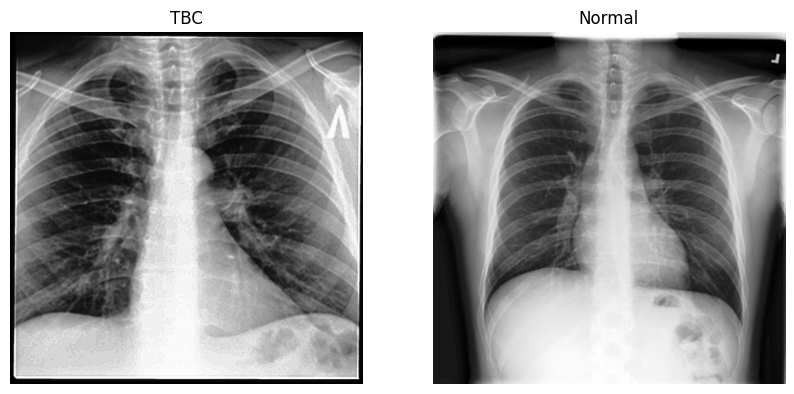

In [7]:
def enhance_image(img):
  #Apply Gaussian Smoothing with a kernel of 5x5
  img_gaussian = cv2.GaussianBlur(img, (5, 5), 0)
  #Additionally, Apply Laplacian Smoothing to highlight edge
  img_laplacian = cv2.Laplacian(img_gaussian, cv2.CV_64F)
  #Sharpen Image by adding the edges from Laplacian Smoothing
  img_sharpened = cv2.convertScaleAbs(img_gaussian - img_laplacian)
  #Apply Histogram Equilization to Increase the Image's Contrast
  img_hist = cv2.equalizeHist(img_sharpened)
  return img_hist

img_tbc_enhanced = enhance_image(img_tbc)
img_normal_enhanced = enhance_image(img_normal)
show_test(img_tbc_enhanced, img_normal_enhanced)

## 3a. Image Segmentation
**Description**: To isolate the lung region from the background, the enhanced images are segmented using Otsu’s thresholding method, which automatically determines the optimal threshold value based on image intensity distribution. After thresholding, the resulting binary mask is inverted so that the lungs become the foreground (white) and the background is suppressed

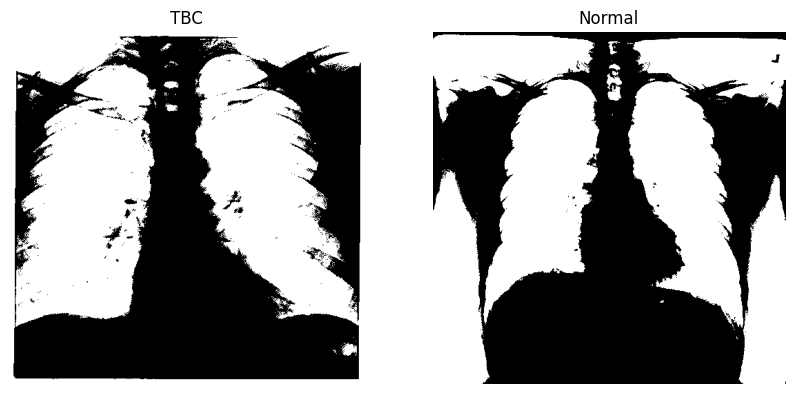

In [8]:
def segment_image(img):
  #Use Otsu Segmentation to Segment both Lungs
  ret, img = cv2.threshold(img, 0, 255,cv2.THRESH_OTSU)
  #Inverse the segmentation so we get the lungs as the foreground
  img = cv2.bitwise_not(img)
  return img

img_tbc_segmented = segment_image(img_tbc_enhanced)
img_normal_segmented = segment_image(img_normal_enhanced)

show_test(img_tbc_segmented, img_normal_segmented)

## 3b. Morphological Processes
**Description**: After segmentation, a morphological opening operation is applied to refine the lung mask. Using an elliptical structuring element (13×13), the opening process effectively removes small noise regions and helps separate adjacent structures that were incorrectly connected during thresholding.

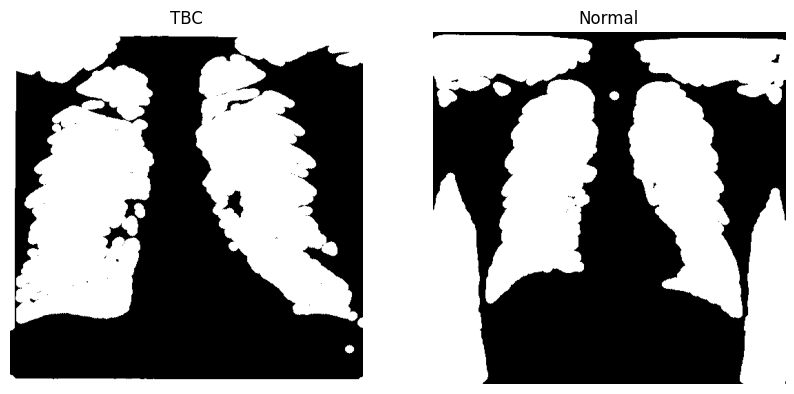

In [9]:
def morphological_process(img):
  #Create Elipse Kernel to use in the Opening Algorithm
  kernel_opening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))

  #Execute Opening Algorithm to remove noise and seperate object
  img_normal_opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_opening)
  return img_normal_opened

img_tbc_opened = morphological_process(img_tbc_segmented)
img_normal_opened = morphological_process(img_normal_segmented)
show_test(img_tbc_opened, img_normal_opened)

## 4. Connected Component Analysis
**Description**: After morphological processing, the segmented image is processed to isolate the actual lung regions. First, connected component analysis is applied to identify all contiguous foreground regions. Each component’s centroid and area are examined, and only components located within the central region of the chest are considered valid lung candidates. The two largest of these candidates are then selected, representing the left and right lungs. Afterwards, A binary mask is constructed by combining these two lung components. To ensure a clean and complete lung region, a morphological closing operation using a 19×19 elliptical kernel is applied, effectively filling small holes and smoothing the boundaries.

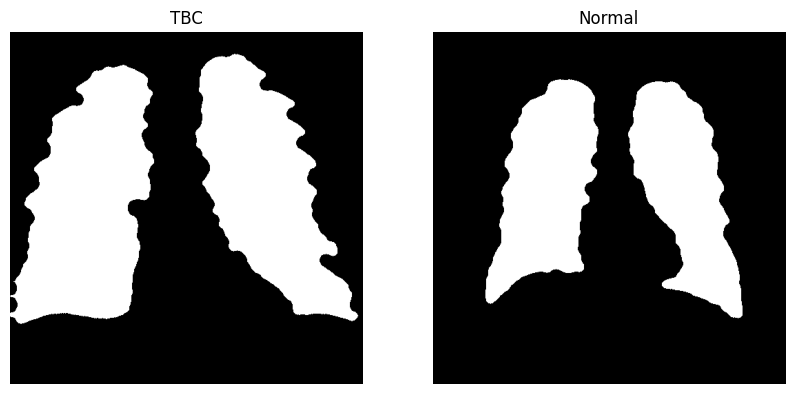

In [10]:
def select_lungs(segmented_image):
  # Find all connected components
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented_image, 8, cv2.CV_32S)

  h, w = segmented_image.shape

  # The first component is usually the background, so we skip it.
  candidates = []
  for i in range(1, num_labels):
    x = centroids[i][0]
    y = centroids[i][1]
    area = stats[i, cv2.CC_STAT_AREA]

    # Lungs must be inside central region of the chest
    if w * 0.2 < x < w * 0.8:   # keep only components near the center
      candidates.append((area, i))

  #Sort by Area
  candidates.sort(key=lambda x: x[0], reverse=True)

  # Create blank images to hold the selected lungs
  lung1_image = np.zeros_like(segmented_image, dtype=np.uint8)
  lung2_image = np.zeros_like(segmented_image, dtype=np.uint8)

  # Select the two largest components (assuming they are the two lungs)
  if len(candidates) >= 1:
    largest_component_id = candidates[0][1]
    lung1_image[labels == largest_component_id] = 255
  if len(candidates) >= 2:
    second_largest_component_id = candidates[1][1]
    lung2_image[labels == second_largest_component_id] = 255

  return lung1_image, lung2_image

def get_mask(img):
  # Select lungs for TBC
  lung1, lung2 = select_lungs(img)
  lungs = cv2.add(lung1, lung2)

  #Create Elipse Kernel to use in the Closing Algorithm
  kernel_closing = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (19, 19))
  #Execute Closing Algorithm to fill in holes
  img = cv2.morphologyEx(lungs, cv2.MORPH_CLOSE, kernel_closing)
  return img

img_tbc_masked = get_mask(img_tbc_opened)
img_normal_masked = get_mask(img_normal_opened)

show_test(img_tbc_masked, img_normal_masked)

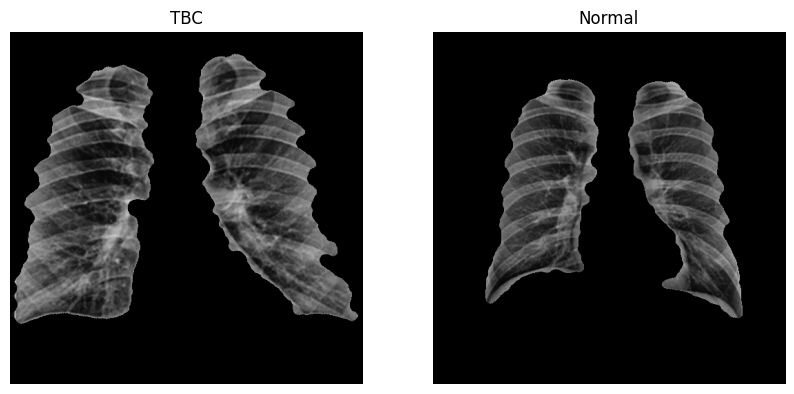

In [11]:
def apply_mask(img, mask):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

  # Apply CLAHE to the enhanced images
  img = clahe.apply(img)

  #Apply Mask using Bitwise And (The arguments are repeated since the function needs two arguments)
  img = cv2.bitwise_and(img, img, mask=mask)
  return img

tbc_masked = apply_mask(img_tbc_enhanced, img_tbc_masked)
normal_masked = apply_mask(img_normal_enhanced, img_normal_masked)
show_test(tbc_masked, normal_masked)

## 5. Feature Extraction and Representation
**Description**: In this section, we will be comparing four texture extraction and representation implementations: Local Binary Patterns (LBP), Gray Level Co-occurrence Matrix (GLCM), and Histogram of Oriented Gradients (HOG), and a combination of the three which forms a single feature vector. First, LBP is applied to capture local micro-texture patterns within the lung region. Using the uniform LBP variant with P=8 sampling points and radius R=1, the method generates a 59-bin histogram representing the frequency of fundamental texture primitives such as edges, flat areas, and spots. The histogram is normalized to ensure scale invariance across different images. The histogram is normalized to ensure scale invariance across different images. Next, GLCM is used to extract higher-order statistical texture features that capture relationships between pixel intensities. The lung image is converted to an 8-bit representation and GLCMs are computed across multiple distances (1, 2, and 3 pixels) and four directional angles (0°, 45°, 90°, and 135°) to ensure robust texture representation across spatial scales and orientations. From each GLCM, a set of established Haralick features, ASM, variance, contrast, dissimilarity, homogeneity, energy, correlation, and entropy are extracted. These descriptors quantify various texture characteristics such as smoothness, heterogeneity, and structural complexity typically altered in diseased tissue. Finally, HOG features are calculated to capture gradient-based structural information. By computing orientation histograms over 8×8 pixel cells with a block normalization scheme (L2-Hys), HOG effectively highlights edge directions and local shape patterns within the lung region. These features help differentiate normal structures from abnormal formations such as lesions and cavities associated with TBC. For the hybrid implementation, the resulting representation from LBP, GLCM, and HOG are concatenated into a single feature vector.

In [ ]:
#Extract LBP Feature
def extract_lbp(image, P=8, R=1):
    lbp = feature.local_binary_pattern(image, P, R, method="uniform")
    # Histogram (59 bins for uniform LBP)
    n_bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype("float")
    hist /= hist.sum()  # normalize
    return hist

#Extract GLCM Feature
def extract_glcm(image):
  image = img_as_ubyte(image) #ensure image is in the correct format (graysclae 0-255)
  distances = [1, 2, 3] #takes texture from multiple spatial scales
  angles = [0, np.pi/4, np.pi/2, 3*np.pi/4] #devicne used angles since textures change depending on the direction
  glcm = feature.graycomatrix(image,
                              distances=distances,
                              angles=angles,
                              levels=256,
                              symmetric=True,
                              normed=True) #Computes GLCM
  features = []
  #Calculate these Haralick features (might add/remove some later)
  props = ['ASM', 'variance', 'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'entropy']

  for prop in props: #Extract Values for each property
    values = feature.graycoprops(glcm, prop).flatten()
    features.extend(values)

  return np.array(features) #Return as an numpy array

#Extract HOG Features
def extract_hog(image):
  #Calculated Histogram of Oriented Gradients
  hog = skimage.feature.hog(image, orientations=9,
                            pixels_per_cell=(8, 8),
                            cells_per_block=(2,2),
                            block_norm='L2-Hys',
                            transform_sqrt = True,
                            feature_vector=True)
  return hog

#Use all prev functions to get the final vector
def extract_features(image):
  lbp_features = extract_lbp(image)
  glcm_features = extract_glcm(image)
  hog_features = extract_hog(image)

  final_vector = np.concatenate((lbp_features, glcm_features, hog_features)) #Combine the vectors
  return final_vector

tbc_features = extract_features(tbc_masked)
normal_features = extract_features(normal_masked)
print(f"TBC Features: {tbc_features.shape}")
print(f"Normal Features: {normal_features.shape}")


TBC Features: (142990,)
Normal Features: (142990,)


## 6. Image Processing

In [13]:
def process_image(img):
  #Image Acquisition
  if len(img.shape) == 3: #Check if already Grayscale, might remove later
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #Image Enhancement
  img_enhanced = enhance_image(img)
  #Image Segmentation
  img = segment_image(img_enhanced)
  #Morphological Processes
  img = morphological_process(img)
  #Getting andApplying Mask
  img = get_mask(img)
  img = apply_mask(img_enhanced, img)
  return img

def process_and_get_vector(img):
  img = process_image(img)
  return extract_features(img)

def process_and_get_glcm(img):
  img = process_image(img)
  return extract_glcm(img)

def process_and_get_hog(img):
  img = process_image(img)
  return extract_hog(img)

def process_and_get_lbp(img):
  img = process_image(img)
  return extract_lbp(img)


img_test = process_image(img_tbc)
img_test2 = process_image(img_normal)
print(f"TBC Features: {process_and_get_vector(img_tbc)}")
print(f"Normal Features: {process_and_get_vector(img_normal)}")

TBC Features: [0.03556442 0.03373337 0.02246475 ... 0.         0.         0.        ]
Normal Features: [0.01786423 0.01780319 0.01591492 ... 0.         0.         0.        ]


## 7a. Image Processing (With Full Pipeline images)

In [38]:
import os

#Set File Location
normal_dir = 'Normal'
tbc_dir = 'Tuberculosis'

#Set Features and Labels to be trained
X = []   # feature vectors
y = []   # labels (0 = normal, 1 = TB)

# Verify whether the directories exists
print(f"Normal directory exists: {os.path.isdir(normal_dir)}")
print(f"Tuberculosis directory exists: {os.path.isdir(tbc_dir)}")

#Preprocess images
def process_folder(folder_path, label):
  #Get all image files
  image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
  total = len(image_files)
  print(f"Found {total} images in {folder_path}.")

  #Process every image in a specific directory
  for i, filename in enumerate(image_files, start=1):
    image_path = os.path.join(folder_path, filename)
    img = cv2.imread(image_path)
    if img is None:
      print(f"Warning: Could not read image {image_path}")
      continue
    
    features = process_and_get_vector(img)
    X.append(features)
    y.append(label)
    print(f"Processed {filename}  ({i}/{total})")

#Process both folders
process_folder(normal_dir, label=0)
process_folder(tbc_dir, label=1)

#Save features and labels into file so i can reuse it later.
np.save("features.npy", np.array(X))
np.save("labels.npy", np.array(y))


Normal directory exists: True
Tuberculosis directory exists: True
Found 3500 images in Normal.
Processed Normal-1.png  (1/3500)
Processed Normal-10.png  (2/3500)
Processed Normal-100.png  (3/3500)
Processed Normal-1000.png  (4/3500)
Processed Normal-1001.png  (5/3500)
Processed Normal-1002.png  (6/3500)
Processed Normal-1003.png  (7/3500)
Processed Normal-1004.png  (8/3500)
Processed Normal-1005.png  (9/3500)
Processed Normal-1006.png  (10/3500)
Processed Normal-1007.png  (11/3500)
Processed Normal-1008.png  (12/3500)
Processed Normal-1009.png  (13/3500)
Processed Normal-101.png  (14/3500)
Processed Normal-1010.png  (15/3500)
Processed Normal-1011.png  (16/3500)
Processed Normal-1012.png  (17/3500)
Processed Normal-1013.png  (18/3500)
Processed Normal-1014.png  (19/3500)
Processed Normal-1015.png  (20/3500)
Processed Normal-1016.png  (21/3500)
Processed Normal-1017.png  (22/3500)
Processed Normal-1018.png  (23/3500)
Processed Normal-1019.png  (24/3500)
Processed Normal-102.png  (25/350

## 7b. Image Processing (Only using GLCM)

In [40]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

#Set File Location
normal_dir = 'Normal'
tbc_dir = 'Tuberculosis'

#Set Features and Labels to be trained
X = []   # feature vectors
y = []   # labels (0 = normal, 1 = TB)

# Verify whether the directories exists
print(f"Normal directory exists: {os.path.isdir(normal_dir)}")
print(f"Tuberculosis directory exists: {os.path.isdir(tbc_dir)}")

#Preprocess images
def process_folder(folder_path, label):
  #Get all image files
  image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
  total = len(image_files)
  print(f"Found {total} images in {folder_path}.")

  #Get Feature Representation for every non-processed image in a specific directory
  for i, filename in enumerate(image_files, start=1):
    image_path = os.path.join(folder_path, filename)
    img = cv2.imread(image_path)
    if img is None:
      print(f"Warning: Could not read image {image_path}")
      continue
    features = process_and_get_glcm(img)
    X.append(features)
    y.append(label)
    print(f"Processed {filename}  ({i}/{total})")

#Process both folders
process_folder(normal_dir, label=0)
process_folder(tbc_dir, label=1)

#Save features and labels into file so i can reuse it later.
np.save("features.npy", np.array(X))
np.save("labels.npy", np.array(y))


Normal directory exists: True
Tuberculosis directory exists: True
Found 3500 images in Normal.
Processed Normal-1.png  (1/3500)
Processed Normal-10.png  (2/3500)
Processed Normal-100.png  (3/3500)
Processed Normal-1000.png  (4/3500)
Processed Normal-1001.png  (5/3500)
Processed Normal-1002.png  (6/3500)
Processed Normal-1003.png  (7/3500)
Processed Normal-1004.png  (8/3500)
Processed Normal-1005.png  (9/3500)
Processed Normal-1006.png  (10/3500)
Processed Normal-1007.png  (11/3500)
Processed Normal-1008.png  (12/3500)
Processed Normal-1009.png  (13/3500)
Processed Normal-101.png  (14/3500)
Processed Normal-1010.png  (15/3500)
Processed Normal-1011.png  (16/3500)
Processed Normal-1012.png  (17/3500)
Processed Normal-1013.png  (18/3500)
Processed Normal-1014.png  (19/3500)
Processed Normal-1015.png  (20/3500)
Processed Normal-1016.png  (21/3500)
Processed Normal-1017.png  (22/3500)
Processed Normal-1018.png  (23/3500)
Processed Normal-1019.png  (24/3500)
Processed Normal-102.png  (25/350

## 7c. Image Processing (Only using HOG)

In [24]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

#Set File Location
normal_dir = 'Normal'
tbc_dir = 'Tuberculosis'

#Set Features and Labels to be trained
X = []   # feature vectors
y = []   # labels (0 = normal, 1 = TB)

# Verify whether the directories exists
print(f"Normal directory exists: {os.path.isdir(normal_dir)}")
print(f"Tuberculosis directory exists: {os.path.isdir(tbc_dir)}")

#Preprocess images
def process_folder(folder_path, label):
  #Get all image files
  image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
  total = len(image_files)
  print(f"Found {total} images in {folder_path}.")

  #Get Feature Representation for every non-processed image in a specific directory
  for i, filename in enumerate(image_files, start=1):
    image_path = os.path.join(folder_path, filename)
    img = cv2.imread(image_path)
    if img is None:
      print(f"Warning: Could not read image {image_path}")
      continue
    features = process_and_get_hog(img)
    X.append(features)
    y.append(label)
    print(f"Processed {filename}  ({i}/{total})")

#Process both folders
process_folder(normal_dir, label=0)
process_folder(tbc_dir, label=1)

#Save features and labels into file so i can reuse it later.
np.save("features.npy", np.array(X))
np.save("labels.npy", np.array(y))


Normal directory exists: True
Tuberculosis directory exists: True
Found 3500 images in Normal.
Processed Normal-1.png  (1/3500)
Processed Normal-10.png  (2/3500)
Processed Normal-100.png  (3/3500)
Processed Normal-1000.png  (4/3500)
Processed Normal-1001.png  (5/3500)
Processed Normal-1002.png  (6/3500)
Processed Normal-1003.png  (7/3500)
Processed Normal-1004.png  (8/3500)
Processed Normal-1005.png  (9/3500)
Processed Normal-1006.png  (10/3500)
Processed Normal-1007.png  (11/3500)
Processed Normal-1008.png  (12/3500)
Processed Normal-1009.png  (13/3500)
Processed Normal-101.png  (14/3500)
Processed Normal-1010.png  (15/3500)
Processed Normal-1011.png  (16/3500)
Processed Normal-1012.png  (17/3500)
Processed Normal-1013.png  (18/3500)
Processed Normal-1014.png  (19/3500)
Processed Normal-1015.png  (20/3500)
Processed Normal-1016.png  (21/3500)
Processed Normal-1017.png  (22/3500)
Processed Normal-1018.png  (23/3500)
Processed Normal-1019.png  (24/3500)
Processed Normal-102.png  (25/350

## 7d. Image Processing (Only using LBP)

In [29]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

#Set File Location
normal_dir = 'Normal'
tbc_dir = 'Tuberculosis'

#Set Features and Labels to be trained
X = []   # feature vectors
y = []   # labels (0 = normal, 1 = TB)

# Verify whether the directories exists
print(f"Normal directory exists: {os.path.isdir(normal_dir)}")
print(f"Tuberculosis directory exists: {os.path.isdir(tbc_dir)}")

#Preprocess images
def process_folder(folder_path, label):
  #Get all image files
  image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
  total = len(image_files)
  print(f"Found {total} images in {folder_path}.")

  #Get Feature Representation for every non-processed image in a specific directory
  for i, filename in enumerate(image_files, start=1):
    image_path = os.path.join(folder_path, filename)
    img = cv2.imread(image_path)
    if img is None:
      print(f"Warning: Could not read image {image_path}")
      continue
    features = process_and_get_lbp(img)
    X.append(features)
    y.append(label)
    print(f"Processed {filename}  ({i}/{total})")

#Process both folders
process_folder(normal_dir, label=0)
process_folder(tbc_dir, label=1)

#Save features and labels into file so i can reuse it later.
np.save("features.npy", np.array(X))
np.save("labels.npy", np.array(y))


Normal directory exists: True
Tuberculosis directory exists: True
Found 3500 images in Normal.
Processed Normal-1.png  (1/3500)
Processed Normal-10.png  (2/3500)
Processed Normal-100.png  (3/3500)
Processed Normal-1000.png  (4/3500)
Processed Normal-1001.png  (5/3500)
Processed Normal-1002.png  (6/3500)
Processed Normal-1003.png  (7/3500)
Processed Normal-1004.png  (8/3500)
Processed Normal-1005.png  (9/3500)
Processed Normal-1006.png  (10/3500)
Processed Normal-1007.png  (11/3500)
Processed Normal-1008.png  (12/3500)
Processed Normal-1009.png  (13/3500)
Processed Normal-101.png  (14/3500)
Processed Normal-1010.png  (15/3500)
Processed Normal-1011.png  (16/3500)
Processed Normal-1012.png  (17/3500)
Processed Normal-1013.png  (18/3500)
Processed Normal-1014.png  (19/3500)
Processed Normal-1015.png  (20/3500)
Processed Normal-1016.png  (21/3500)
Processed Normal-1017.png  (22/3500)
Processed Normal-1018.png  (23/3500)
Processed Normal-1019.png  (24/3500)
Processed Normal-102.png  (25/350

## 8. Machine Learning

In [51]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import joblib

# Load features & labels
X = np.load("features.npy")
y = np.load("labels.npy")

# 1. Split Dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# 2. Train Model (Logistic Regression)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 3. Evaluate Accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# 4. Save model
joblib.dump(model, "model.pkl")

print("Model saved as model.pkl")


Accuracy: 0.9523809523809523
Model saved as model.pkl


c:\Users\Anders\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score

# Load trained model
model = joblib.load("model.pkl")

# Make predictions
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print("Confusion Matrix:\n", cm)

sensitivity = tp / (tp + fn)  # True Positive Rate
specificity = tn / (tn + fp)  # True Negative Rate
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Sensitivity (Recall for TBC): {sensitivity:.4f}")
print(f"Specificity (Recall for Normal): {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-score: {f1:.4f}")


Test Accuracy: 0.9523809523809523
Confusion Matrix:
 [[687  16]
 [ 24 113]]
Sensitivity (Recall for TBC): 0.8248
Specificity (Recall for Normal): 0.9772
Precision: 0.8760
F1-score: 0.8496


In [55]:
import os
import cv2
import joblib

model_path = "model.pkl"
scaler_path = "scaler.pkl"
filename = "normal.png"
model = joblib.load(model_path)


# Read image
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (512, 512))
feature_vector = process_and_get_glcm(img)

prediction = model.predict([feature_vector])

if (prediction == 1):
    print("TBC")
else:
    print("Normal")

Normal
